In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
import qt3utils.experiments.cwodmr
import qt3utils.analysis.aggregation

import qt3utils.nidaq.config

In [3]:
import qcsapphire
import qt3rfsynthcontrol
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
pulser = qcsapphire.Pulser('COM10')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [26]:
qt3utils.nidaq.config.reset_daq('Dev1')

In [54]:
cwodmr = qt3utils.experiments.cwodmr.CWODMR(rfsynth, 
                                            freq_low = 2846e6, 
                                            freq_high = 2890e6, 
                                            freq_step = 4e6,
                                           N_cycles_per_frequency=500000)

In [55]:
def run_scan(rf_freq, post_data_acq_process = None):
    
    clock_terminal = 'PFI0'
    spcm_terminal = 'PFI12'
    trigger_terminal = 'PFI1'

    rfsynth.rf_on(0)
    time.sleep(0.1) #wait for RF box to turn on

    full_cycle_ticks, period = cwodmr.pulser_setup(pulser, rf_width=5e-6)
    N_samples = int(full_cycle_ticks * cwodmr.N_cycles_per_frequency)
    daq_time = N_samples * period
    
    edge_config = qt3utils.nidaq.config.EdgeCounter()
    edge_config.configure_counter_period_measure(source_terminal = spcm_terminal,
                                                 N_samples_to_acquire_or_buffer_size = N_samples, 
                                                 clock_terminal = clock_terminal,
                                                trigger_terminal = trigger_terminal)
    edge_config.create_counter_reader()

    pulser.system.state(1) #turn on the pulser
    data = []
    
    for rf_freq in rf_freq:
        rf_freq = np.round(rf_freq, 9)
        print(f'RF frequency: {rf_freq*1e-9} GHz')
        rfsynth.set_channel_fixed_output(0, cwodmr.rf_power, rf_freq)
        print(f'Acquiring {N_samples} at sample period of {period} seconds: total {daq_time} seconds')
        
        data_buffer = np.zeros(N_samples)
        
        edge_config.counter_task.start()
        time.sleep(daq_time*1.1)
        
        read_samples = edge_config.counter_reader.read_many_sample_double(
                                data_buffer,
                                number_of_samples_per_channel=N_samples,
                                timeout=5)
        
        edge_config.counter_task.stop()
        if post_data_acq_process:
            data_buffer = post_data_acq_process(data_buffer, cwodmr.N_cycles_per_frequency, full_cycle_ticks)
            
        data.append([rf_freq, int(full_cycle_ticks), period, data_buffer])
    
    rfsynth.rf_off(0)
    time.sleep(0.05) #wait for RF box
    return data


In [60]:
scan_data = run_scan(cwodmr.frequencies, qt3utils.analysis.aggregation.reshape_sum_trace)

RF frequency: 2.846 GHz
Acquiring 25000000 at sample period of 2e-07 seconds: total 5.0 seconds
RF frequency: 2.85 GHz
Acquiring 25000000 at sample period of 2e-07 seconds: total 5.0 seconds
RF frequency: 2.854 GHz
Acquiring 25000000 at sample period of 2e-07 seconds: total 5.0 seconds
RF frequency: 2.858 GHz
Acquiring 25000000 at sample period of 2e-07 seconds: total 5.0 seconds
RF frequency: 2.862 GHz
Acquiring 25000000 at sample period of 2e-07 seconds: total 5.0 seconds
RF frequency: 2.866 GHz
Acquiring 25000000 at sample period of 2e-07 seconds: total 5.0 seconds
RF frequency: 2.87 GHz
Acquiring 25000000 at sample period of 2e-07 seconds: total 5.0 seconds
RF frequency: 2.874 GHz
Acquiring 25000000 at sample period of 2e-07 seconds: total 5.0 seconds
RF frequency: 2.878 GHz
Acquiring 25000000 at sample period of 2e-07 seconds: total 5.0 seconds
RF frequency: 2.882 GHz
Acquiring 25000000 at sample period of 2e-07 seconds: total 5.0 seconds
RF frequency: 2.886 GHz
Acquiring 25000000

In [61]:
def plot_rolled_trace(trace, N_cycles, N_samples_per_cycle, clock_rate, shift=0):
    trace = np.roll(trace,shift)
    plt.plot(np.arange(N_samples_per_cycle) / clock_rate, trace/N_cycles * clock_rate)

C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "_unnamedTask<7>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(


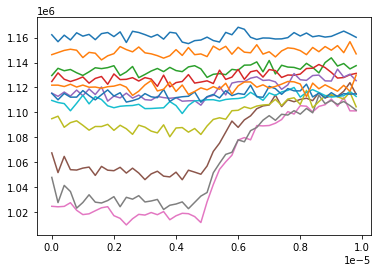

In [62]:
for scan_i in range(len(scan_data)):
    plot_rolled_trace(scan_data[scan_i][3], cwodmr.N_cycles_per_frequency, scan_data[scan_i][1], 1./scan_data[scan_i][2], 0)

In [65]:
np.save('v7_cwodmr_raw',  scan_data, allow_pickle=True)

C:\Users\QT3\anaconda3\envs\qdl-dev\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [66]:
scan_data

[[2846000000.0,
  50,
  2e-07,
  array([116227., 115670., 116194., 115810., 116386., 116116., 116258.,
         115833., 116319., 116407., 116081., 116460., 115607., 116506.,
         116410., 116238., 116040., 116248., 115877., 116427., 116360.,
         115640., 115517., 115755., 115806., 116037., 115764., 115644.,
         116418., 116228., 116831., 116669., 116028., 115851., 115970.,
         115960., 115889., 115899., 115998., 116402., 116128., 116368.,
         116066., 116150., 116041., 116100., 116311., 116521., 116284.,
         116024.])],
 [2850000000.0,
  50,
  2e-07,
  array([114630., 114801., 114971., 115067., 114986., 114397., 114814.,
         114747., 114209., 114538., 114712., 115279., 115037., 114857.,
         115246., 114778., 114698., 114551., 114352., 114544., 115034.,
         114570., 115202., 114629., 114689., 114475., 115313., 115014.,
         115300., 114667., 115223., 114830., 114782., 115427., 114676.,
         114864., 114450., 114930., 115176., 115121.,

## Analysis

Data above shows contrast at various frequencies. Next step in analysis would be to integrate between 
the first half and last half of the data